Osnabrück University - A&C: Computational Cognition (Summer Term 2019)

# Exercise Sheet 05: Eye tracking

## Introduction

This week's sheet should be solved and handed in at 14:00 at **Tuesday, May 28, 2019**. If you need help (and Google and other resources were not enough), feel free to contact your tutors. Please push your results to your Github group folder.

For this exercise sheet you will have 2 weeks and the sheet is also worth of 30 points. In this exercise sheet you will start to work with eye tracking data. Note that the data we will use here are not raw gaze data and contain coordinates of fixation points.

The dataset is distributed freely by a following study: [Wilming, N. Dryad](https://www.nature.com/articles/sdata2016126#data-citations). By clicking on the link in the section "Data Citations" you will get redirected to the page where you can download all the data openly distributed. Read below for description of each file.

##### necessary
*etdb_v1.0*: This is the main data file. The hdf5 file consists of all the fixation data and the metadata.  
*Read gaze data with python*: Python script to read hdf5 file as a dataframe.  
*Stimuli/i*: Zip file containing image stimuli used in the study. The encoding convention is same as in the dataframe.
##### optional
*Metadata*: This is the csv file giving overview of all studies.

In [2]:
%pip install h5py # make sure to install h5py which is used in fixmat.py

Note: you may need to restart the kernel to use updated packages.


In [3]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.anova import *
from statsmodels.formula.api import ols
from datas.fixmat import *
import matplotlib.patches as mpatches

## Assignment 0: Peer review for sheet 04 [3 pts]

Each group reviews the solutions of two other groups and give points according to the given point distribution considering the correctness of the solution. For this reviews the tutors will give you up to 3 points each week. Follow a distributed comment guidelines if you are unsure.

| * |Group 1|Group 2|Group 3|Group 4|Group 5|Group 6|Group 7|Group 8|Group 9|Group 10|Group 11|
| ------- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ------ | ------ |
| check solutions of group: | 5, 9 | 1, 6  | 4, 7  | 7, 2 | 2, 11 | 8, 3 | 3, 10  | 11, 1  | 10, 4  | 6, 8  | 9, 5   |


## Assignment 1: Checking the data distribution [9 pts]

### a) loading datasets [0 pts]
As with any other datasets, the first step is to get an idea of the dataset. Check the meta data and column of the dataframe.

In [4]:
# use a fixmat.py to load the hdf5 format data as a panda dataframe
df, meta = load('datas/etdb_v1.0.hdf5', "Baseline")

In [5]:
meta

{'# Fix.': 203772,
 '# Obs.': 48,
 'Age': '23.1 (19-28)',
 'Article': 15.0,
 'Categories': '7,8,10,11',
 'Disp. Size (degree)': '29x22',
 'Display': 'SM1100',
 'Display resolution (pixels)': '1280x960',
 'Eye Tracker': 'EL II',
 'ID': 3,
 'Img. Pos. (pixel)': '0,0',
 'Img. size (pixel)': '1280x960',
 'PPD': 45.6,
 'Sampling freq. (Hz)': '500 Hz',
 'Task': 'FV',
 'V. Dur.': '6s',
 'V. dist. (cm) ': 80,
 'Val. error (degrees)': 0.3}

### b) data cleaning [3 pts]
We want to clean the dataframe so that it is handy for us to work with it.
- How many fixations do we have per category? ```agg``` function might be helpful.
- categories are encoded using a number. Add a column to the dataframe that has approporiate string value for that category (e.g. code 11.0 to "Pink-noise"). The category names can be found on Figure 2 of the paper.
- since measurements lasted for 6 seconds, any fixation points that have a onset time before 0 sec and end time more than 6 sec are erroneous. Remove these rows.
- also remove all rows with any NaN values.
- add a column called ```duration``` and compute the duration of each fixation.
- It is known from previous literature that fixations typically last between 100 msec to 400 msec. Remove all rows with unrealistic  fixation duration.
- check how many data points got removed for each category. Let's hope that we didn't delete too many rows from a single category.
- count the number of fixations for each trial. To do this, you can use the aggregate method to count the number of rows for each category.
- print the mean duration and the mean number of fixation across all trials. Are they in a realistic range?

In [6]:
# Add column with decoded categories
df['decoded category'] = df['category'].map({7: 'Natural', 8: 'Urban', 10: 'Fractals', 11: 'Pink Noise'})

# Number of fixations per category
fix_points_cat = df.groupby(['decoded category']).count()['SUBJECTINDEX']
# Remove all fixations befor the stimulus onset
clean_df = df[df['start'] >= 0]
# Remove all fixations after stimulus offsetand remove all lines with NaN values.
clean_df = clean_df[clean_df['end'] <= 6000].dropna()
# Add duration column
clean_df['duration'] = clean_df['end'] - clean_df['start']
# Clean all lines with unrealistic duration
clean_df = clean_df[(clean_df['duration'] <= 400) & (clean_df['duration'] >= 100)]
# Count the number of removed points per category
removed_points = (fix_points_cat - clean_df.groupby(['decoded category']).count()['SUBJECTINDEX'])
# Group dataframe be subject index and trial. Count for every trial the number of fixations
fixations_per_trial = clean_df.groupby(['SUBJECTINDEX','trial'])['category'].count()
# Calculate the mean number of fixations
mean_fixations = fixations_per_trial.mean()
# Calculate the mean duration of fixations
mean_duration = clean_df['duration'].mean()
# Print results

print('Number of removed points per category: \n', removed_points)
print()
print('Number of remaining points in category: \n', clean_df.groupby(['decoded category']).count()['SUBJECTINDEX'])
print()
print('Mean number of fixations per trial: ', mean_fixations)
print('Mean duration of fixations: ', mean_duration)
print('Time covered per trial in the mean: 12.5*240 ms =', 12.5* 2400, 'ms')



Number of removed points per category: 
 decoded category
Fractals      12979
Natural       12554
Pink Noise    14603
Urban         11835
Name: SUBJECTINDEX, dtype: int64

Number of remaining points in category: 
 decoded category
Fractals      39922
Natural       39784
Pink Noise    27250
Urban         44845
Name: SUBJECTINDEX, dtype: int64

Mean number of fixations per trial:  12.551761203902762
Mean duration of fixations:  240.49106
Time covered per trial in the mean: 12.5*240 ms = 30000.0 ms


The remaining dataset is still pretty large even after removing the invalid data points. The average time covered is 3 seconds which seems realistic if we consider, that we removed a large number of fixation points and some time is needed for the saccade.

### c) visualizing data distribution [3 pts]
Are there any inter-subject difference and effect of different category in our data?
- plot the mean duration for each category (4 x-values) and the mean duration for each subject (48 x-values).

- plot the mean number of fixations for each category (4 x-values) and the mean number of fixation for each subject (48 x-values).

In [7]:
# TODO

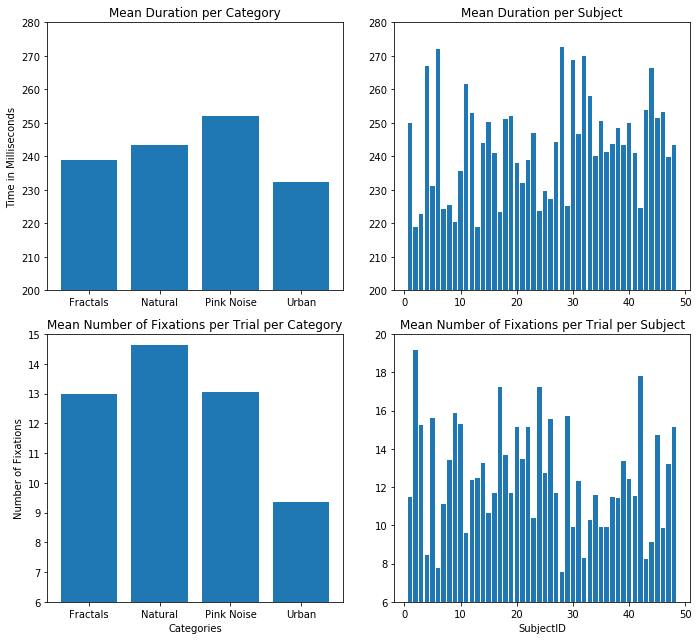

In [27]:
# Create figure
fig, axes = plt.subplots(2,2)
fig.set_size_inches(10,9)
# Make a barplot of the mean duration for each category
axes[0,0].bar(clean_df.groupby('decoded category')['duration'].mean().index, clean_df.groupby('decoded category')['duration'].mean().values)
# Set y limits to appropriate values
axes[0,0].set(ylim=(200,280), title='Mean Duration per Category', ylabel='Time in Milliseconds')
# Make a barplot of the mean number of fixations per trial per subject
axes[0,1].bar(clean_df.groupby('SUBJECTINDEX')['duration'].mean().index,
            clean_df.groupby('SUBJECTINDEX')['duration'].mean().values)
# Set y limits to appropriate values
axes[0,1].set(ylim=(200,280), title='Mean Duration per Subject')

# Make a barplot of the mean number of fixations for each category
axes[1,0].bar(clean_df.groupby(['decoded category','SUBJECTINDEX', 'trial']).count().groupby('decoded category').mean().index, clean_df.groupby(['category','SUBJECTINDEX', 'trial']).count().groupby('category').mean()['y'].values)
axes[1,0].set(ylim=(6,15), title='Mean Number of Fixations per Trial per Category', xlabel='Categories', ylabel='Number of Fixations')

# Make a barplot of the mean number of fixations per Subject
axes[1,1].bar(clean_df.groupby(['category','SUBJECTINDEX', 'trial']).count().groupby('SUBJECTINDEX').mean().index,clean_df.groupby(['category','SUBJECTINDEX', 'trial']).count().groupby('SUBJECTINDEX').mean()['y'].values)
axes[1,1].set(ylim=(6,20), title='Mean Number of Fixations per Trial per Subject', xlabel='SubjectID', )

fig.tight_layout()

### d) normally distributed data [3 pts]
As ANOVA and lots of other statistical tests can be used only for normally distributed varaibles, it makes sense to find out whether the fixation duration and the number of fixations per trial is also normally distributed. This can be done with a Q-Q-Plot, which  is a graphical technique for determining if two data sets come from populations with a common distribution, in this case a normal distribution (for more information, klick [here](https://www.itl.nist.gov/div898/handbook/eda/section3/eda33o.htm)).
- make a Q-Q plot of the variable *fixation duration*. Is it approximately normally distributed?
- make a Q-Q plot of the variable *# fixation per trial*. Is it approximately normally distributed?

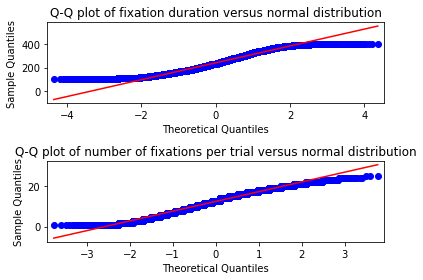

In [9]:
# Create figure
figure, ax = plt.subplots(2)
# Plot the duration of the fixations against a normal distribution
prob = sm.ProbPlot(clean_df['duration'], dist='norm')
prob.qqplot(line='r', ax=ax[0])
# Plot the  fixations per trial against a normal distribution
prob = sm.ProbPlot(fixations_per_trial, dist='norm')
prob.qqplot(line='r', ax=ax[1])
ax[0].set_title('Q-Q plot of fixation duration versus normal distribution')
ax[1].set_title('Q-Q plot of number of fixations per trial versus normal distribution')
figure.tight_layout()

what do you think?

The two variable seem not to be normally distributed. There seems to be a systematic difference between the normal and the the underlying distributions.

## Assignment 2: Hypothesis testing [3 pts]

### a) one way ANOVA [3 pts]
Now it's time to really prove our intuition. Test the following null hypotheses:  
$H01$: There is no difference in fixation duration across 4 different categories.  
$H02$: There is no difference in the number of fixations across 4 different categories.

What do you find?

In [10]:
model = ols('duration ~ category', clean_df).fit()

#create anovas typ 1 and print them
table = sm.stats.anova_lm(model, typ=1)
print(table)

                df        sum_sq       mean_sq           F        PR(>F)
category       1.0  1.330038e+06  1.330038e+06  246.995531  1.298364e-55
Residual  151799.0  8.174172e+08  5.384865e+03         NaN           NaN


In [11]:
model = ols('fix ~ category', clean_df).fit()

#create anovas typ 1 and print them
table = sm.stats.anova_lm(model, typ=1)
print(table)

                df        sum_sq       mean_sq          F         PR(>F)
category       1.0  1.323439e+04  13234.390199  459.92918  7.062423e-102
Residual  151799.0  4.367992e+06     28.774844        NaN            NaN


what do you say?

Based on the ANOVA tables both Hypotheses seems to be correct, as the result is in the significant 5% range. 

## Assignment 3: Binning [4 pts]

### a) distribution of # fixation [2 pts]
Now we would like to know if there's a difference in terms of fixation numbers at different time segment.
- make a histogram with x axis being the start time of fixation
- the bin size should be 1 sec. In total there would be 6 bins.
- average over all subjects and images, just make a one simple plot
- figure out mean fixation duration for each bin and print it


In [12]:
# TODO

### b) leftward bias [2 pts]
If you took Action & Cognition I, you have probably heard about the leftward bias in human's fixation behavior. It is known that people tend to look more at the left visual field for the initial first second. Check whether this holds for our dataset as well.
- make a pointplot with x-axis as the x-coordinate of each fixation point and y-axis as the time bin to which the fixation point belongs to.
- mark the confidence interval around each point.
- make a vertical line at middle point of the x values. The x-coordinate of the fixation point in the data is based on the coordinate system using the display resolution. You can find out the information about display resolution by taking a look at the meta data.

In [13]:
# TODO

## Assignment 4: Heatmap [4 pts]
Now let's use heatmap to visualize which part of pictures is fixated for how long. It would be also good to know if there's a difference between categories.
- make a heatmap for data consisting of each categories and then averaged across all data.
- mark a central point in the plot.
- you can use ```numpy.histogram2d``` to compute a bi-dimensional histogram.
- then you can use ```pyplot.imshow``` to plot these histogram.
- don't forget to use the parameter ```extent``` to control for the bounding box to which the image should fit in.
- if you want to use other functions that's surely fine as well.

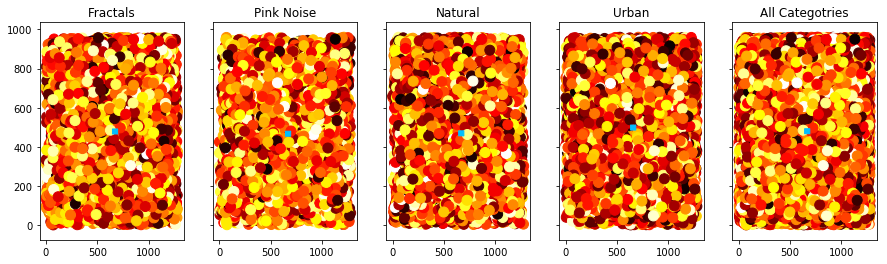

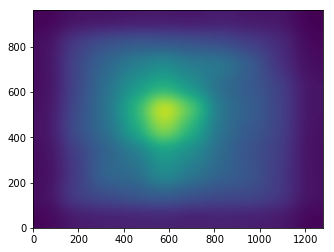

In [14]:
plots = 5
fig, axes = plt.subplots(nrows=1, ncols=plots, sharey=True, figsize=(15, 4))

# iterate through the categories and make a heatmap for each
for counter, item in enumerate(set(clean_df['decoded category'])):
    # heatmap for this category
    axes[counter].scatter(clean_df[clean_df['decoded category'] == item]['x'], clean_df[clean_df['decoded category'] == item]['y'], c=clean_df[clean_df['decoded category'] == item]['duration'], s=100, cmap=plt.cm.get_cmap('hot'))
    # set category as title
    axes[counter].set_title(item)
    # set the mean point
    p1 = mpatches.FancyBboxPatch((clean_df[clean_df['decoded category'] == item]['x'].mean(),clean_df[clean_df['decoded category'] == item]['y'].mean()),width = 50, height = 25, color='#00BFFF')
    axes[counter].add_patch(p1)
# make heatmap for all categories together
axes[4].scatter(clean_df['x'], clean_df['y'], c=clean_df['duration'], s=100, cmap=plt.cm.get_cmap('hot'))
# set title for heatmap
axes[4].set_title('All Categotries')
#set the mean point
p1 = mpatches.FancyBboxPatch((clean_df['x'].mean(),clean_df['y'].mean()),width = 50, height = 25, color='#00BFFF')
axes[4].add_patch(p1)

plt.show()

# make the bidimensional histogram
H, xedges, yedges = np.histogram2d(clean_df['x'], clean_df['y'])
plt.imshow(H, interpolation='gaussian', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])




## Assignment 5: Scanpath [5 pts]
We want to know whether different scan behaviour is used when viewing images of different categories. Scanpath is a path followed by the eyes when viewing a stimulus. Scanpaths are useful for analyzing cognitive intent, interest, and salience. It has an advantage to a heatmap because the information about temporal structure of viewing behaviour can be plotted.
- make four plots, one for each category.
- randomely choose one trial for which you will plot a scanpath.
- mark fixation points based on the x-y coordinates.
- plot the *saccade path* from one fixation point to another one.
- make sure that the order of fixation can be read out from the plot. E.g. earlier fixations could have a light color whereas later fixations could have dark colors.
- also include information about the duration of each fixation. One way to do it is the use the size of the fixation marker.
- plot the background image superimposed with the scanpath. 

In [15]:
# TODO

# Citation
Wilming N, Onat S, Ossandón J, Acik A, Kietzmann TC, Kaspar K, Gameiro RR, Vormberg A, König P (2017) An extensive dataset of eye movements during viewing of complex images. Scientific Data 4: 160126. https://doi.org/10.1038/sdata.2016.126  
Wilming N, Onat S, Ossandón J, Acik A, Kietzmann TC, Kaspar K, Gameiro RR, Vormberg A, König P (2017) Data from: An extensive dataset of eye movements during viewing of complex images. Dryad Digital Repository. https://doi.org/10.5061/dryad.9pf75